In [ ]:
!pip install talib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 5.3 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
import requests
from io import StringIO
import matplotlib.pyplot as plt 
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import talib as ta
import json
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Bidirectional
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import math
from sklearn import model_selection



#Import CSV file
df = pd.read_csv ('SET 50 Historical Data.csv')
df = df.iloc[::-1] #Switch the order

df['Price'] = df['Price'].replace({'\$': '', ',': ''}, regex=True).astype(float) #remove , and convert to float

df = df.set_index('Date') #set Date
df = df['Price']
df = pd.DataFrame(df)
target_col = 'Price'


In [ ]:
# #Create EMA colum
# df['EMA']= ta.EMA(df['Price'],20)
# df = df['EMA']
# df = df.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)


In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(df[['Price']], df[['EMA']], test_size=.3,shuffle=False)


In [ ]:
#Convert to Max Min

scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))#normal2


# X_train=scaler.fit_transform(np.array(X_train).reshape(-1,1))
# X_test=scaler.fit_transform(np.array(X_test).reshape(-1,1))
# y_train=scaler.fit_transform(np.array(y_train).reshape(-1,1))
# y_test=scaler.fit_transform(np.array(y_test).reshape(-1,1))

In [ ]:
#split2

training_size=int(len(df)*0.8)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]




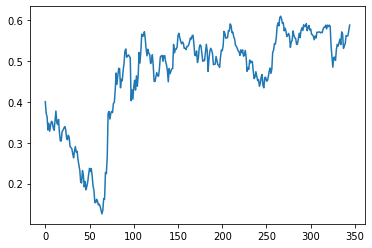

In [ ]:
plt.plot(y_test)

In [ ]:
# train_data = np.array(train_data).reshape(-1,1)
# test_data = np.array(test_data).reshape(-1,1)
# train_data.shape


(851, 1)

In [ ]:
def create_dataset(input_data, time_step=1):
  X,Y = [],[]
  for i in range(len(input_data)-time_step-1):
    a = input_data[i:i+time_step,0]
    #a = a-input_data[i]
    X.append(a)
    #Y.append(input_data[i+time_step+1,0]-input_data[i+time_step,0])
    #Y.append(input_data[i+time_step,0]-input_data[i+time_step-1,0])
    Y.append(input_data[i + time_step, 0])#notmod

  return np.array(X),np.array(Y)


In [ ]:
time_step = 5
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [ ]:
print(y_train.shape,X_train.shape,X_test.shape,y_test.shape)

(830,) (830, 20) (345, 20) (345,)


In [ ]:
# # set parameter for model
# np.random.seed(42)
# window_len = 10
# zero_base = True
# lstm_neurons = 100
# epochs = 100
# batch_size = 32
# loss = 'mse'
# dropout = 0.2
# optimizer = 'adam'
# test_size = 0.4

In [ ]:
# #Create model function
# def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
#                      dropout=0.2, loss = 'mean_squared_error', optimizer='adam'):
#     model = Sequential()
#     model.add(LSTM(neurons, return_sequences=True, input_shape=(input_data.shape[1], input_data.shape[2])))
#     model.add(Dropout(dropout))
#     model.add(LSTM(neurons))
#     model.add(Dense(output_size))
#     #model.add(Activation(activ_func))

#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model

In [ ]:
model=keras.Sequential()
model.add(layers.LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(layers.LSTM(100,return_sequences=False))
#model.add(layers.LSTM(50))
model.add(Dropout(0.2))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size= 64, epochs=50)

In [ ]:
#set up model
#model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,optimizer=optimizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 50)             10400     
                                                                 
 dropout_1 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size= 64, epochs=50)

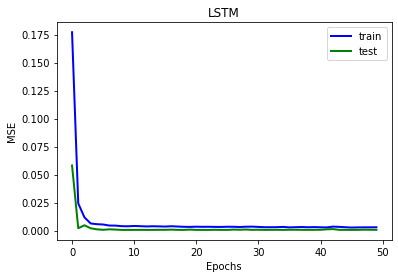

In [ ]:
plt.plot(history.history['loss'],'b',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)


In [ ]:
# #accuracy_test
# model.save('accuracy')
# y_test_dummies = pd.get_dummies(y_test).values
# print('Shape of Label tensor: ', y_test_dummies.shape)# model evaluation
# from keras.models import load_model

# model = load_model('accuracy')
# scores = model.evaluate(X_test, y_test_dummies)


# LSTM_accuracy = scores[1]

# print('Test accuracy: ', scores[1], '%')

In [ ]:
#convert to normal price
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
 y_test = y_test.reshape(-1,1)
 y_test2 = scaler.inverse_transform(y_test)


In [ ]:
# test_predict=scaler.fit_transform(np.array(test_predict).reshape(-1,1))

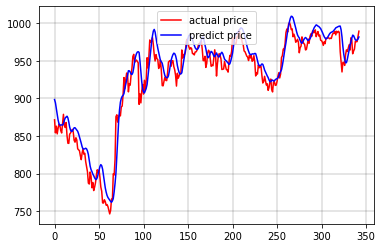

In [ ]:
# # train_predict=scaler.inverse_transform(train_predict)
# test_predict=scaler.inverse_transform(test_predict)
# y_test2 = scaler.inverse_transform(y_test)

plt.plot(y_test2,'r',label="actual price")
plt.grid(color='black', linestyle='-', linewidth=0.2)
plt.rcParams["figure.figsize"] = [40,15]
plt.plot(test_predict,'b',label="predict price")
#plt.plot(dftest[-320:],'y')
leg = plt.legend(loc='upper center')
plt.show()




In [ ]:

print("Mean Absolute Error:", mean_absolute_error(y_test2, test_predict))
print("Coefficient of Determination:", r2_score(y_test2,test_predict))
print("Mean Squared Error:", mean_squared_error(y_test2, test_predict))
print("Mean Per Error:", mean_absolute_percentage_error(y_test2,test_predict))
print("Root Mean Squared Error:",math.sqrt(mean_squared_error(y_test2, test_predict)))

Mean Absolute Error: 12.62049146290771
Coefficient of Determination: 0.9286779943034393
Mean Squared Error: 276.67557423152465
Mean Per Error: 0.013938734292407919
Root Mean Squared Error: 16.633567694019362


In [ ]:
count = 0
for i in range (len(y_test2)):
  if (y_test2[i]-y_test2[i-1]>0)==(test_predict[i]-test_predict[i-1]>0)or(y_test2[i]-y_test2[i-1]>0)==(test_predict[i]-test_predict[i-1]>0):
    count = count+1

In [ ]:
Acc =  (count*100)/(len(y_test2-1))
print('Accuracy',Acc,'%')

Accuracy 50.72886297376093 %
